/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_99601/2938601942.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


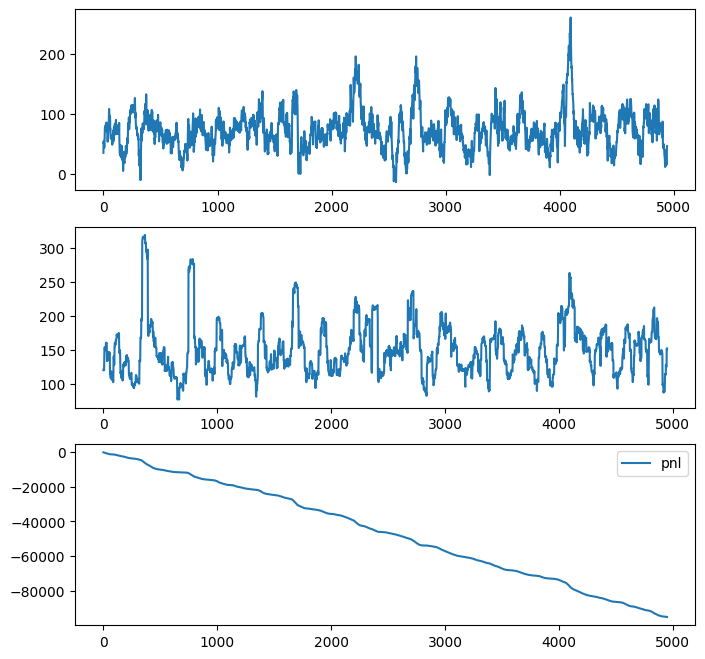

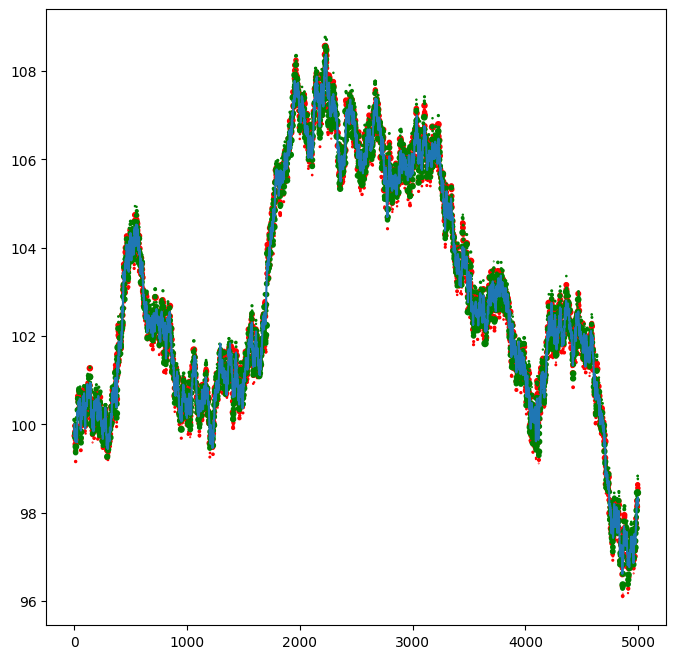

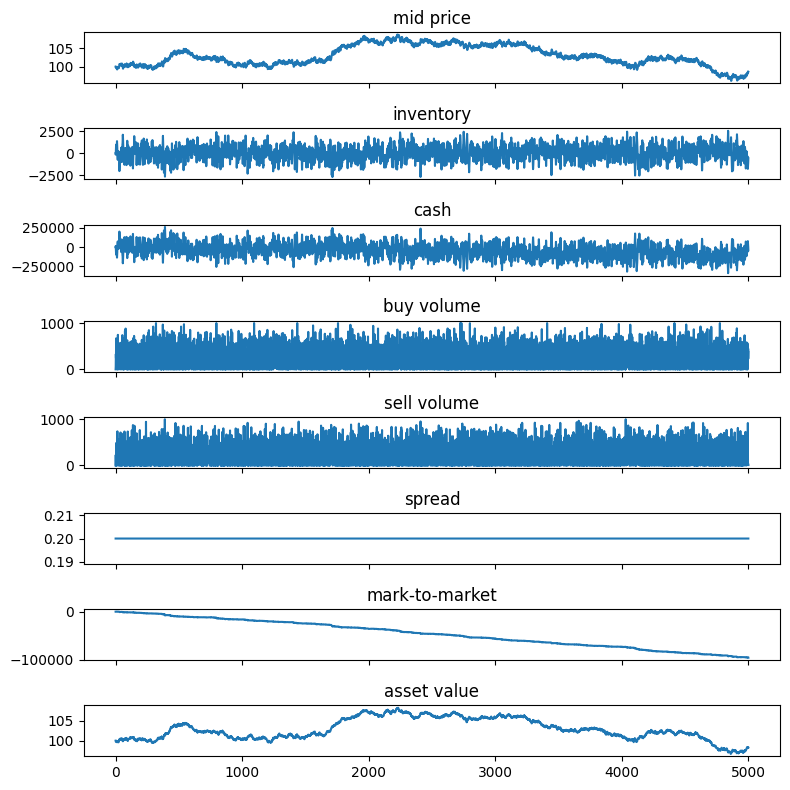

In [34]:
from lob_sim import (
    OrderBook,
    MarketMaker,
    SkewMarketMakingStrategy,
    InformedTraders,
    Asset,
)
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=20)
a = Asset()
ob = OrderBook(min_lifetime=0)
strat = SkewMarketMakingStrategy(0.2, 1000, 1_000_000_000,skew_coefficient=4e-6)
mm = MarketMaker(strat)
it = InformedTraders(0.8, 10, 100)
timesteps = 5000
trades_notifications = []

asset_value = []
bid_price_volume_history = []
ask_price_volume_history = []
for _ in range(timesteps):
    bid_price_volume = {}
    ask_price_volume = {}
    ob.advance()
    quotes, cancellations = mm.update(ob, trades_notifications)
    market_orders = it.generate_orders(a.value, ob.mid_price, rng=rng)
    ob.process_cancellations(cancellations)
    notifs = ob.process_orders(chain(quotes, market_orders))
    trades_notifications = notifs[1]
    for notif in trades_notifications:
        if notif.is_bid:
            for p, v in notif.price_volume.items():
                bid_price_volume[p] = bid_price_volume.get(p, 0) + v
        else: 
             for p, v in notif.price_volume.items():
                ask_price_volume[p] = ask_price_volume.get(p, 0) + v
    bid_price_volume_history.append(bid_price_volume)
    ask_price_volume_history.append(ask_price_volume)
    price_volume = {}
    asset_value.append(a.value)
    a.evolve_value(rng=rng)

def moving_avg(array, window_size):
    window_size = window_size if len(array) > window_size else len(array)
    cumsum = np.cumsum(np.insert(array, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size 

def markout(mm_history, tau, window_size=50):
    net_volume = np.array(mm_history["buy volume"]) - np.array(mm_history["sell volume"])
    mid_price = np.array(mm_history["mid price"])
    
    # Future price change: mid[t+tau] - mid[t]
    delta_mp = mid_price[tau:] - mid_price[:-tau]
    
    # Markout only defined for times where we have t+tau data
    markout = -(net_volume[:-tau] * delta_mp)
    
    markout = moving_avg(markout, window_size)
    
    return markout

def inventory_risk(mm_history, window_size=50):
    inventory = np.array(mm_history["inventory"])
    mp = np.array(mm_history["mid price"])
    delta_mp = mp[1:] - mp[:-1]
    delta_exposure = inventory[:-1] * delta_mp
    E_x = moving_avg(delta_exposure, window_size)
    E_x2 = moving_avg(delta_exposure ** 2, window_size)
    return np.sqrt(E_x2 - E_x ** 2)

mo = markout(mm.history, 10, 50)
ir = inventory_risk(mm.history, 50)
pnl = moving_avg(mm.history["mark-to-market"], 50)

fi, a = plt.subplots(nrows=3, figsize=(8,8))
a[0].plot(mo, label="markout")
a[1].plot(ir, label="inventory risk")
a[2].plot(pnl, label="pnl")
plt.legend()

tau = np.arange(1,50,1)
def markout_curves(mm_history, tau_list, t):
    curve = []
    for tau in tau_list:
        curve.append(markout(mm_history, tau)[t])
    return curve


history = mm.history
x_bid = []
x_ask = []
y_bid = []
y_ask = []
s_ask = []
s_bid =[]
for t, pv in enumerate(bid_price_volume_history):
    x_bid.extend([t]*len(pv))
    y_bid.extend(list(pv.keys()))
    s_bid.extend(list(pv.values()))
for t, pv in enumerate(ask_price_volume_history):
    x_ask.extend([t]*len(pv))
    y_ask.extend(list(pv.keys()))
    s_ask.extend(list(pv.values()))

s_ask = np.array(s_ask)/50
s_bid = np.array(s_bid)/50

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x_bid,y_bid,s_bid, color='r')
ax.scatter(x_ask,y_ask,s_ask, color='g')
ax.plot(asset_value)
    
fig, ax = plt.subplots(nrows=len(history) + 1, sharex=True, figsize=(8,8))
for idx, (key, value) in enumerate(history.items()):
    ax[idx].plot(value)
    ax[idx].set_title(key)
ax[-1].plot(asset_value)
ax[-1].set_title("asset value")
fig.tight_layout()
fig.show()

In [42]:
# for simulations we want to be able to control the skew coefficient for skew optimisation and
def simulate(informed_frac, skew_coefficient, n=10, timesteps=1000, rng=None):
    avg_metrics = {}
    for i in range(n):
        metrics = simulate_path(informed_frac, skew_coefficient, timesteps, rng)
        if i == 0:
            for k in metrics.keys():
                avg_metrics[k] = 0
        for k, v in metrics.items():
            avg_metrics[k] += v
    
    for k in metrics.keys():
        avg_metrics[k] /= n 
    
    return avg_metrics


def simulate_path(informed_frac, skew_coefficient, timesteps=1000, rng=None):
    # set random number generator for reproducibility
    if rng == None:
        rng = np.random.default_rng(seed=42)

    a = Asset()
    ob = OrderBook(min_lifetime=0)
    strat = SkewMarketMakingStrategy(
        0.2, 1000, 1_000_000_000, skew_coefficient=skew_coefficient
    )
    mm = MarketMaker(strat)
    it = InformedTraders(informed_frac, 10, 100)

    # list of latest trades_notifications to be processed by the market maker
    trades_notifications = []
    for _ in range(timesteps):
        # market maker updates quotes
        quotes, cancellations = mm.update(ob, trades_notifications)

        # background flow of informed and uninformed traders
        market_orders = it.generate_orders(a.value, ob.mid_price, rng=rng)

        # cancel old quotes made by the market maker
        ob.process_cancellations(cancellations)

        # process trades for the tick: [t, t+1)
        notifs = ob.process_orders(chain(quotes, market_orders))
        trades_notifications = notifs[1] if 1 in notifs else []

        # evolve the value of the asset
        a.evolve_value(rng=rng)
    
    return process_market_maker_data(mm)

    
def process_market_maker_data(market_maker):
    history = market_maker.history

    # CALCULATE SHARPE

    mtm = market_maker.history["mark-to-market"]
    sharpe = np.mean(mtm)/np.std(mtm)
    final_pnl = mtm[-1]

    # CALCULATE MARKOUT
    tau = 5
    net_volume = np.array(history["buy volume"]) - np.array(history["sell volume"])
    mid_price = np.array(history["mid price"])
    delta_mp = mid_price[tau:] - mid_price[:-tau]
    markout = np.mean(-(net_volume[:-tau] * delta_mp))

    # CALCULATE INVENTORY RISK standard deviation of exposure swing per tick.

    inventory = np.array(history["inventory"])
    delta_mp = mid_price[1:] - mid_price[:-1]
    delta_exposure = inventory[:-1] * delta_mp
    inventory_risk = np.std(delta_exposure)

    # CALCULATE MEAN INVENTORY
    
    mean_inventory = np.mean(inventory)
    
    return {
        "final pnl" : final_pnl,
        "sharpe": sharpe,
        "markout": markout, 
        "inventory risk": inventory_risk,
        "mean inventory": mean_inventory
    }

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_99601/950719307.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


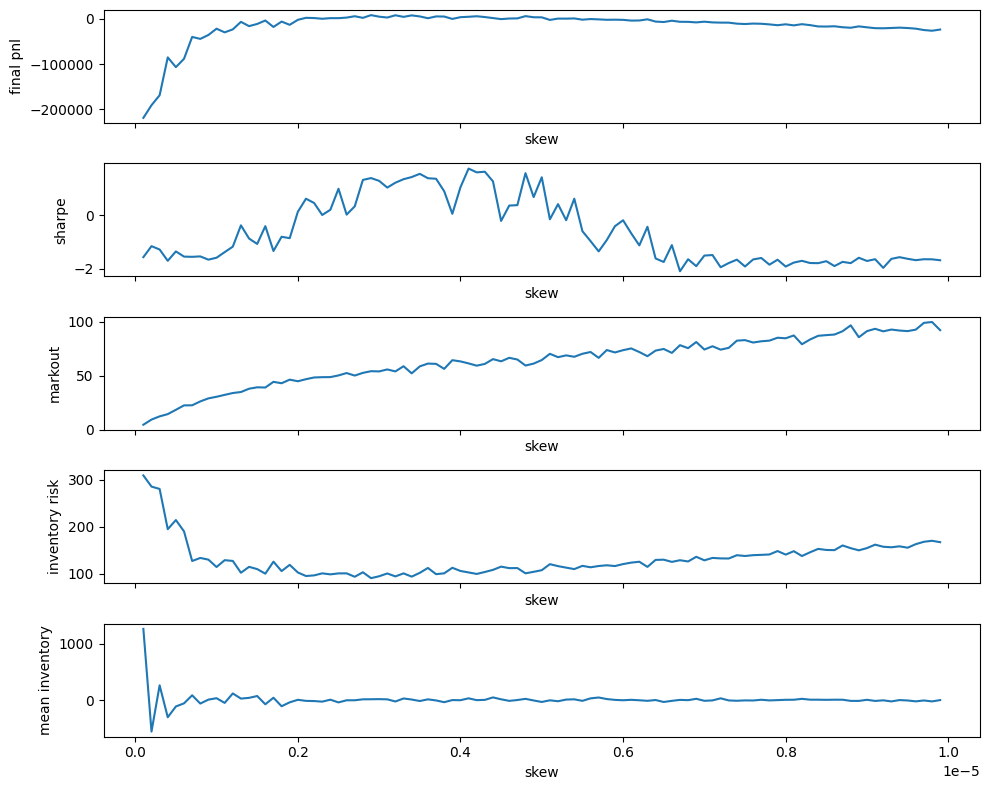

In [46]:
import pandas as pd
rng = np.random.default_rng(seed=1)
skew_coefficients = np.arange(1e-7, 1e-5, 1e-7)
results = []
for sc in skew_coefficients:
    avg_metrics = simulate(0.5, sc, n=5, rng=rng, timesteps=1000)
    avg_metrics["skew"] = sc
    results.append(avg_metrics)

df = pd.DataFrame(results)
metrics_to_plot = ["final pnl", "sharpe", "markout", "inventory risk", "mean inventory"]

fig, ax = plt.subplots(nrows=len(metrics_to_plot), figsize=(10,8), sharex=True)

for ax, metric in zip(ax, metrics_to_plot):
    ax.plot(df['skew'], df[metric])
    ax.set_ylabel(metric)
    ax.set_xlabel('skew')

fig.tight_layout()
fig.show()
    
